# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Final Random Forest Model ##
- Start with our optimized model from before ($R^2 = 0.687$, max_depth = 18, max_features = 5)
- Error analysis

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from itertools import combinations
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [2]:
# Load listing data
listing = pd.read_csv('../../Data/data_after_predictor_selection.csv')
listing.head(2)

,accommodates,bathrooms,bedrooms,review_scores_checkin,review_scores_communication,latitude,longitude,property_type_0,property_type_1,property_type_2,...,bed_type_2,bed_type_3,bed_type_4,beds,review_scores_value,host_listing_count,review_scores_cleanliness,review_scores_accuracy,minimum_nights,price
0,2,1.0,1.0,9.0,9.0,40.756852,-73.964754,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,1,7.0,9.0,3,160
1,10,1.0,3.0,9.0,8.0,40.830599,-73.941014,1.0,0.0,0.0,...,0.0,0.0,0.0,3.0,8.0,2,8.0,8.0,1,105


In [6]:
y = np.log(listing["price"])
x = listing[[col for col in listing.columns if col != "price"]]
print x.shape
print y.shape

(27392, 27)
(27392,)


## Location Clustering Feature

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neighbors import KNeighborsRegressor

class LocationPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = KNeighborsRegressor(n_neighbors=50, weights="uniform")
        super(LocationPreprocessor, self).__init__()
        
    def fit_transform(self, X, y):
        self.model.fit(X[["longitude", "latitude"]], y)
        return self.transform(X)
    
    def transform(self, X):
        loc = self.model.predict(X[["longitude", "latitude"]])
        Xnew = X.copy()
        Xnew["location"] = loc
        return Xnew

## Build Model

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
model = Pipeline([
            ("location", LocationPreprocessor()),
            ("rf", RandomForestRegressor(n_estimators=150, max_depth=18, max_features=5))
        ])
model.fit(x_train, y_train)
print "Train Score", model.score(x_train, y_train)
print "Test Score", model.score(x_test, y_test)

Train Score 0.88020361985
Test Score 0.700301598143


## Error Analysis

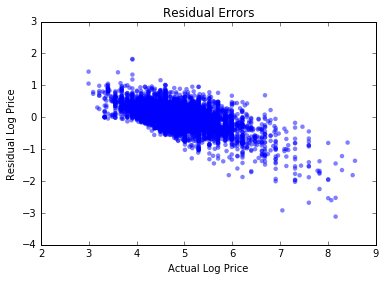

In [14]:
resid = model.predict(x_test) - y_test
plt.figure()
plt.scatter(y_test, resid, edgecolors='none', alpha=0.5)
plt.xlabel("Actual Log Price")
plt.ylabel("Residual Log Price")
plt.title("Residual Errors");

Much of our error comes from outliers with high prices.

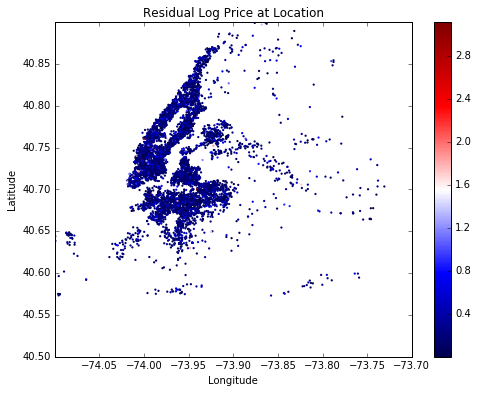

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(x_test["longitude"], x_test["latitude"], c=np.abs(resid), s=5, edgecolors='none', cmap="seismic")
plt.title("Residual Log Price at Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim((-74.1, -73.7))
plt.ylim((40.5, 40.9))
plt.colorbar();

There is no obvious pattern of residuals by location.